# Get pixel value from mosaic Daymet file
In this tutorial we will retrieve two Daymet variables (`tmax`, `tmin`) for a location (`35.5N`, `87.0W` degrees) and time period `2011` to `2015`. 

First, let's import the modules.

In [1]:
# import modules
import netCDF4 as nc
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Proj

Now, set the required variables.

In [2]:
# daymet root directory where the mosaic files are located
daymet_dir = '/daymet_data/V4/CFMosaic_na/'

# set min and max years
daymet_yrs = list(range(2011, 2016))
# set  Daymet variables
bands = ['tmax', 'tmin']
# coordinates in degrees of the location of interest
lat = 35.5
lon = -87.0

Let's convert the above defined coordinates to Daymet's LCC coordinates.

In [3]:
# function to convert latlon to LCC 
def latlon_to_lcc(lon, lat):
    # defining LCC projection of Daymet
    p = Proj("+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs")
    lcc_xy = p(lon, lat)
    return lcc_xy

# getting lambert coordinates
lambert_x, lambert_y = latlon_to_lcc(lon, lat)

# print
print(f"LCC coordinates of ({lon}, {lat}) degrees is ({lambert_x}, {lambert_y}) meters")

LCC coordinates of (-87.0, 35.5) degrees is (1130243.6926487826, -655231.8105294534) meters


Now, let's loop over the years and bands and retrieve daymet pixel values.

In [4]:
# initialize arrays to store time, variables, and pixel values
daymet_vars = []
daymet_time = []
daymet_data = []

# loop through the years 
for daymet_yr in daymet_yrs:
    # loop through the bands
    for band in bands:
        # path of the mosaic file
        mosaic_f = path.join(daymet_dir, f'{daymet_yr}', f'{band}.nc')
        
        # repeat the band name 365 times
        daymet_vars.extend([band] * 365)

        # open mosaic netcdf
        mosaic_nc = nc.Dataset(mosaic_f)
        
        # read x, y 
        xs = mosaic_nc['x'][:]
        ys = mosaic_nc['y'][:]
        
        # find the closest pixel
        iyy = (np.abs(ys - lambert_y)).argmin()
        ixx = (np.abs(xs - lambert_x)).argmin()
        
        # retrieve daymet data for whole 365 days
        daymet_data.extend(mosaic_nc[band][:, iyy, ixx].tolist())
        
        # retrieve daymet time
        dm_time = mosaic_nc['time']
        daymet_time.extend(nc.num2date(dm_time[:], units=dm_time.units))
        
        # close the mosaic netcdf
        mosaic_nc.close()          

In [5]:
# put the lists into a pandas dataframe
pixel_df = pd.DataFrame(list(zip(daymet_vars, daymet_time, daymet_data)), 
                        columns = ['Vars', 'DateTime', 'Pixel_Value'])
# print
pixel_df

,Vars,DateTime,Pixel_Value
0,tmax,2011-01-01 12:00:00,10.90
1,tmax,2011-01-02 12:00:00,3.54
2,tmax,2011-01-03 12:00:00,7.75
3,tmax,2011-01-04 12:00:00,12.60
4,tmax,2011-01-05 12:00:00,4.21
...,...,...,...
3645,tmin,2015-12-27 12:00:00,15.95
3646,tmin,2015-12-28 12:00:00,13.30
3647,tmin,2015-12-29 12:00:00,6.31
3648,tmin,2015-12-30 12:00:00,4.79


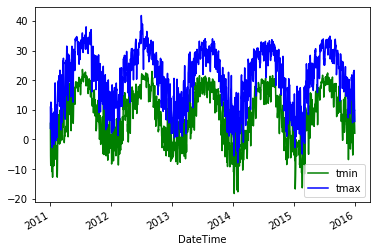

In [6]:
# plot
ax = pixel_df[pixel_df.Vars=='tmin'].plot(x='DateTime', y='Pixel_Value', label='tmin', color='g')
pixel_df[pixel_df.Vars=='tmax'].plot(ax=ax, x='DateTime', y='Pixel_Value', label='tmax', color='b')